<a href="https://colab.research.google.com/github/sarim711/BiomedBERT_Medical-Text_Classification/blob/main/BiomedBERT_MedicalText_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with BERT

In [ ]:
#load libraries necessary for TF-IDF classification
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import re
import matplotlib.pyplot as plt
import spacy
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

In [ ]:
#load corpus
df = pd.read_csv("covid_df.csv")
df = df.sample(len(df))

In [ ]:
def assign_train_test_split(df, train_size=0.8, valid_size=0.1, random_state=None):
    df['Split'] = "Test"
    train_indices = df.sample(frac=train_size, random_state=random_state).index
    df.loc[train_indices, 'Split'] = "Train"

    nb_valid = int(valid_size * len(df))
    valid_indices = df.loc[df['Split'] == "Test"].sample(n=nb_valid, random_state=random_state).index
    df.loc[valid_indices, 'Split'] = "Valid"

    return df

# Example usage:
df = pd.read_csv("covid_df.csv")
df = assign_train_test_split(df, train_size=0.8, valid_size=0.1, random_state=42)
df





,doc_id,Title,Abstract,Year,Split
0,37943961,Correction is courageous.,In a year when disagreements over scientific m...,2023,Train
1,37943932,Open science discovery of potent noncovalent S...,"We report the results of the COVID Moonshot, a...",2023,Test
2,37797027,Mapping SARS-CoV-2 antigenic relationships and...,During the severe acute respiratory syndrome c...,2023,Train
3,37616383,Will climate change amplify epidemics and give...,While the world recovers from the COVID-19 pan...,2023,Train
4,37471538,Genomic assessment of invasion dynamics of SAR...,Severe acute respiratory syndrome coronavirus ...,2023,Train
...,...,...,...,...,...
217,32234804,An investigation of transmission control measu...,Responding to an outbreak of a novel coronavir...,2020,Train
218,32213647,The effect of human mobility and control measu...,The ongoing coronavirus disease 2019 (COVID-19...,2020,Test
219,32179701,Substantial undocumented infection facilitates...,Estimation of the prevalence and contagiousnes...,2020,Train
220,32144116,The effect of travel restrictions on the sprea...,Motivated by the rapid spread of coronavirus d...,2020,Train


In [ ]:
#Did your function work?
# Assertion checks
assert np.fabs(len(df[df["Split"] == "Train"]) - len(df) * 0.8) < 10
assert np.fabs(len(df[df["Split"] == "Valid"]) - len(df) * 0.1) < 10
assert np.fabs(len(df[df["Split"] == "Test"]) - len(df) * 0.1) < 10


In [ ]:

nlp = spacy.load("en_core_web_sm") #this could take a minute to download the first time

In [ ]:
def clean(sentence):
    sentence = nlp(sentence)
    ret = []
    for word in sentence:
        if word.is_stop: continue
        lem = word.lemma_
        ret.append(lem)
    spacy_cleaned = " ".join(ret)
    sent = re.sub('[^A-Za-z]', ' ', spacy_cleaned)
    sent = re.sub('\s+', ' ', sent)
    return sent

df["Abstract_Cleaned"] = df["Abstract"].apply(clean)

In [ ]:
def get_tfidf_vectors_and_labels(df, split = "Train", max_features = 100):
    #new TF-IDF vectorizer considering only the 1000 most common terms
    vectorizer = TfidfVectorizer(max_features=max_features)
    #compute the TF-IDF vectors for each cleaned abstract
    vectorizer.fit(df[df.Split=="Train"]["Abstract_Cleaned"])
    vectors = vectorizer.transform(df[df.Split==split]["Abstract_Cleaned"])

    labels = df[df.Split==split]["Year"]
    return vectors.toarray(), labels

In [ ]:
def get_tfidf_vectors_and_labels(df, split="Train", max_features=100):
    # New TF-IDF vectorizer considering only the specified number of most common terms
    vectorizer = TfidfVectorizer(max_features=max_features)

    # Compute the TF-IDF vectors for each cleaned abstract in the training set
    vectorizer.fit(df[df.Split == "Train"]["Abstract_Cleaned"])

    # Get the TF-IDF vectors for the specified split
    vectors = vectorizer.transform(df[df.Split == split]["Abstract_Cleaned"]).toarray()

    # Get the labels for the specified split
    labels = df[df.Split == split]["Year"]


    return vectors, labels


train_vectors, train_labels = get_tfidf_vectors_and_labels(df, split="Train", max_features=100)



In [ ]:
vectorizer = TfidfVectorizer(max_features=100)
vectorizer.fit(df[df.Split == "Train"]["Abstract_Cleaned"])

vocabulary = vectorizer.get_feature_names_out()
vocabulary


array(['ace', 'activity', 'acute', 'age', 'analysis', 'animal',
       'antibody', 'antiviral', 'bind', 'case', 'cause', 'cell', 'change',
       'child', 'concern', 'contact', 'control', 'coronavirus', 'country',
       'cov', 'covid', 'critical', 'datum', 'death', 'delta', 'design',
       'disease', 'domain', 'dose', 'early', 'epidemic', 'epitope',
       'escape', 'estimate', 'find', 'future', 'global', 'health', 'high',
       'human', 'identify', 'ifn', 'immune', 'immunity', 'include',
       'increase', 'individual', 'infection', 'intervention', 'lead',
       'lineage', 'low', 'model', 'month', 'mutation', 'need',
       'neutralization', 'neutralize', 'new', 'number', 'omicron',
       'pandemic', 'patient', 'population', 'protein', 'provide',
       'public', 'rate', 'rbd', 'receptor', 'reduce', 'report',
       'respiratory', 'response', 'result', 'reveal', 'risk', 'rna',
       'sars', 'severe', 'specific', 'spike', 'spread', 'structure',
       'study', 'suggest', 'syndrom

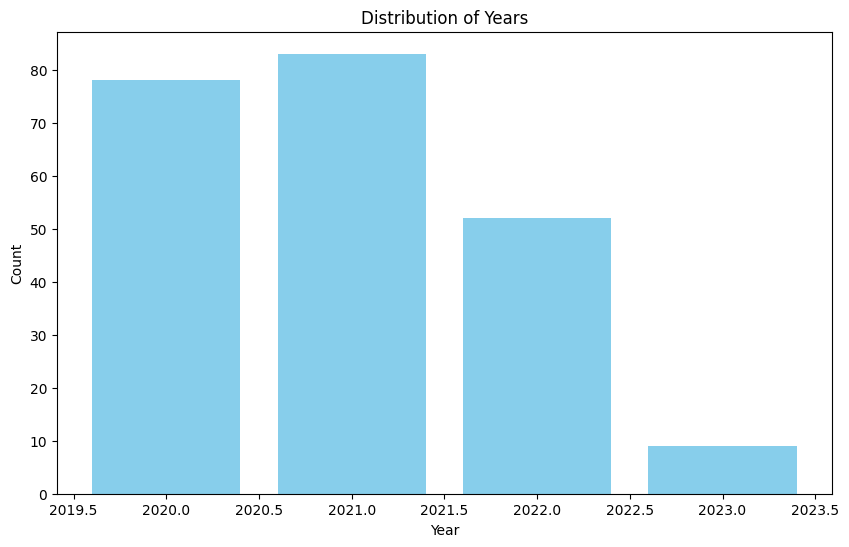

In [ ]:
# Plotting
years_distribution = df["Year"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(years_distribution.index, years_distribution.values, color='skyblue')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()


In [ ]:


# 1. Train and return the classifier
def train_tfidf_classifier(vectors_train, labels_train):
    model = LogisticRegression()
    model.fit(vectors_train, labels_train)
    return model

# 2. Predict and return metrics
def evaluate_model(model, vectors, labels, average='macro'):
    predictions = model.predict(vectors)
    f1 = f1_score(labels, predictions, average=average)
    return predictions, f1

# 3. Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(title)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

# 4. Final test evaluation (e.g. after tuning)
def run_final_evaluation(df, max_features, class_labels):
    # Get vectors & labels
    vectors_train, labels_train = get_tfidf_vectors_and_labels(df, split="Train", max_features=max_features)
    vectors_test, labels_test = get_tfidf_vectors_and_labels(df, split="Test", max_features=max_features)

    # Train and evaluate
    model = train_tfidf_classifier(vectors_train, labels_train)
    predictions_test, _ = evaluate_model(model, vectors_test, labels_test)

    # Confusion matrix
    plot_confusion_matrix(labels_test, predictions_test, class_labels, title="TF-IDF Confusion Matrix")

# 5. Hyperparameter tuning across different max_features values
def find_best_max_features(df, max_features_list):
    f1_scores_train = []
    f1_scores_valid = []
    best_max_features = None
    best_f1_valid = 0.0

    for max_features in max_features_list:
        vectors_train, labels_train = get_tfidf_vectors_and_labels(df, split="Train", max_features=max_features)
        vectors_valid, labels_valid = get_tfidf_vectors_and_labels(df, split="Valid", max_features=max_features)

        model = train_tfidf_classifier(vectors_train, labels_train)

        _, f1_train = evaluate_model(model, vectors_train, labels_train)
        _, f1_valid = evaluate_model(model, vectors_valid, labels_valid)

        f1_scores_train.append(f1_train)
        f1_scores_valid.append(f1_valid)

        if f1_valid > best_f1_valid:
            best_f1_valid = f1_valid
            best_max_features = max_features

    # Plot
    plt.plot(np.arange(len(max_features_list)), f1_scores_train, label="F1 Train")
    plt.plot(np.arange(len(max_features_list)), f1_scores_valid, label="F1 Valid")
    plt.xticks(np.arange(len(max_features_list)), max_features_list)
    plt.xlabel("Vocabulary size (max_features)")
    plt.ylabel("F1 Score (Macro)")
    plt.title("TF-IDF Performance Tuning")
    plt.legend()
    plt.show()

    print(f"\nOptimal max_features: {best_max_features} (Validation F1 Score: {best_f1_valid:.4f})")
    return best_max_features



In [ ]:
best_max_features

100

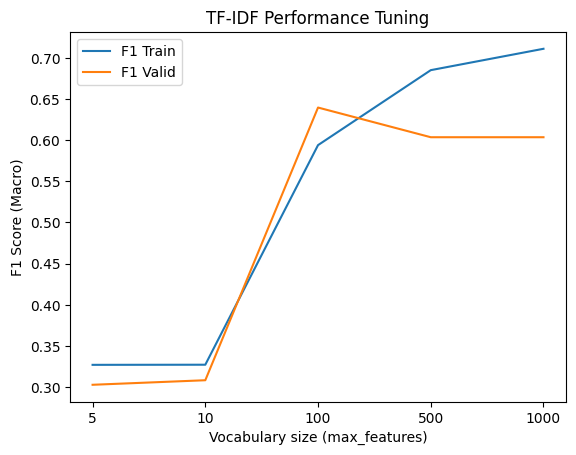


Optimal max_features: 100 (Validation F1 Score: 0.6396)


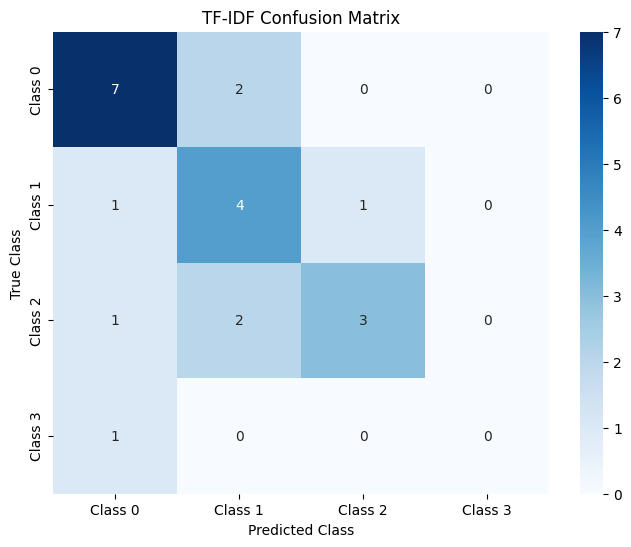

In [ ]:
# Define the max_features array you want to test (vocabulary sizes)
max_features_list = [5, 10, 100, 500, 1000]

#  Tune the max_features to get the best one
best_max_features = find_best_max_features(df, max_features_list)

# Run final evaluation on the test set with the best_max_features
class_labels = ["Class 0", "Class 1", "Class 2", "Class 3"]  # Replace with your actual class labels
run_final_evaluation(df, best_max_features, class_labels)

# BERT for Text Classification

Using classification model, BERT. BERT (read more [here](https://arxiv.org/abs/1810.04805)) is a Transformer network (read more [here](https://arxiv.org/abs/1706.03762)). That means that it is a deep neural network in which each layer is actual comprised of a Transformer block, whose architecture is described in the linked paper - read more about it in this illustration [here](https://jalammar.github.io/illustrated-transformer/).

BERT is useful for text classification because it generates a latent representation for every input token based on its context. The output of BERT is there an $Nx768$ dimensional matrix, where $N$ is the number of tokens in the sequence input, and 768 is the size of token vectors produced by BERT. (Note: other models use different sized representations. The larger the representation, the more precise they can be, but also the more resources they require to both train and evaluate). We can then use these latent representations as inputs to a downstream task (such as sentence classification).

We perform sentence classification by evaluating the special classification token that we insert at the very beginning of sentences before passing them to BERT. The self-attention mechanism (see the previously linked articles for more information) allows for a latent representation of the classifier token to reflect the input text as a whole.

In [ ]:
!pip install transformers tokenizers
import torch
import transformers
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # progress bar for batches

In [ ]:
if torch.cuda.is_available():
    print('GPU available!')
    device = torch.cuda.current_device()
else:
    print('GPU unavailable - CPU will be used for all calculations')
    device = None

GPU available!


Using a pre-trained bio-medical BERT model i.e. model PubMedBert (read about it [here](https://huggingface.co/microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract)). It has been trained on abstracts from PubMed!

In [ ]:
#huggingface name for the model
model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"

In [ ]:
# Load tokenizer directly
tokenizer = AutoTokenizer.from_pretrained(model_name, )

max_length=128 #a typical value for short documents like abstracts

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

Tokenizing an entire corpus

In [ ]:
MAX_LEN = max_length
def do_tokenisation(texts, max_length):
    if not texts:  # Check if texts is empty
        return None

    tokeniser_output = tokenizer(
        texts,
        padding='max_length',  # pad shorter sequences to max_length
        truncation=True,  # truncate longer sequences to max_length
        max_length=max_length
    )

    for encoding in tokeniser_output:
        tokeniser_output[encoding] = torch.tensor(tokeniser_output[encoding])

    return tokeniser_output

train_tokeniser_output = do_tokenisation(df[df.Split == "Train"].Abstract_Cleaned.tolist(), MAX_LEN)
valid_tokeniser_output = do_tokenisation(df[df.Split == "Valid"].Abstract_Cleaned.tolist(), MAX_LEN)
test_tokeniser_output = do_tokenisation(df[df.Split == "Test"].Abstract_Cleaned.tolist(), MAX_LEN)

Example of the encodings produced by the tokenizer.

In [ ]:
batch_idx = 5
original_sentence = df.Abstract_Cleaned[batch_idx]
print(f'Input sentence:\n{original_sentence}\n')
tokens = train_tokeniser_output.tokens(batch_idx)
print(f'Tokens:\n{tokens}\n')
input_ids = train_tokeniser_output['input_ids'][batch_idx]
print(f'Input IDs:\n{input_ids}\n')
attention_mask = train_tokeniser_output['attention_mask'][batch_idx]
print(f'Attention Mask:\n{attention_mask}\n')

Input sentence:
U S government project bet big intranasal vaccine monoclonal antibody omit ambitious approach 

Tokens:
['[CLS]', 'current', 'vaccine', 'tailor', 'combat', 'future', 'sars', 'cov', 'variant', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

In [ ]:
max_len_corpus = max(len(tokenizer.encode(text)) for text in df['Abstract_Cleaned'])
print("Maximum length in the corpus:", max_len_corpus)


Maximum length in the corpus: 153


## Language Model

 Hugging Face API to load the pre-trained weights of a transformer language model for inference.

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification
#AutoModelForSequenceClassification is an API that appends a linear classifer layer to
#the classifier token of a BERT network. Alternately, one can do this onseself in torch
#by creating a new class.

The ``config`` attribute contains hyperparameter values including vocabulary size, dropout probabilities, and architectural specifications

In [ ]:
model_config = AutoConfig.from_pretrained(model_name)
print(model_config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.50.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
model_config.num_labels = 4

The ``model`` object we use here is an instantiation of the pre-trained PubMedBert model with an extra classification layer added.

In [ ]:
model = AutoModelForSequenceClassification.from_config(model_config)

In [ ]:
# the constructor function requires the parameters of the language model and the learning rate as input

optimizer = AdamW(tuple(model.parameters()), lr=2e-5)

In [ ]:
# here we define a simple subclass of the Pytorch Dataset object: the DataLoader by default will access the amount
# of data points stored by instances of this subclass, as well as indexing it, so we have to overwrite the __len__
# and __getitem__ methods to make sure it will behave as we would like

class ClassificationDataset(Dataset):
    def __init__(self, df, split):
        super().__init__()
        self.df = df[df.Split==split]
        self.tokeniser_output = do_tokenisation(self.df.Abstract_Cleaned.tolist(), MAX_LEN)
        self.labels = self.df.Year.values-2020

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        input_ids, att_mask = self.tokeniser_output["input_ids"][idx], self.tokeniser_output["attention_mask"][idx]
        label = self.labels[idx]
        return (input_ids, att_mask, label)

train_dataset = ClassificationDataset(df,"Train")
valid_dataset = ClassificationDataset(df,"Valid")

In [ ]:
BATCH_SIZE = 4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

## Training a Classifier
To fine-tune the PubMedBert word embeddings for our document classification task, we use the ``[CLS]`` token from the final layer of the transformer neural network to predict the relevant class for each sentence. To output class probabilities based on the word embedding vectors, a linear prediction layer is stacked on top of the transformer network, which will learn weight parameters $w$ that correspond to the optimal transformation of the ``[CLS]`` vector into a vector of scores for each class in the output space (usually called _logits_). To generate class probabilities from the logit vector, the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is applied:

$$
\phi_w:\mathbb{R}^{d_{\text{EMB}}}\rightarrow\mathbb{R}^{d_{\text{CLASS}}} \\
\text{Classifier}\left(x_{\text{CLS}}\right)=\text{softmax}\left(\phi_w\left(x_{\text{CLS}}\right)\right)
$$

For the model we use in this tutorial, we have embedding dimension $d_{\text{EMB}}=768$ and because we have ten hallmarks of cancer plus the absence of a hallmark, we have output dimension $d_{\text{CLASS}}=4$.

To predict a single class, however, we just need to pick out the dimension of the logit vector with the highest score:

$$\text{Predicted Class}=\text{argmax}\left(\phi\left(x_{\text{CLS}}\right)\right)$$


In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
N_EPOCHS = 20

Training the model from scratch using PubmedBERT model configuration without pretrained weights

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

def train_model(model=None):
    total_train_f1 = []
    total_valid_f1 = []
    total_train_loss = []
    total_valid_loss = []

    # reset the model if you run this cell more than once!
    if model is None:
        model = AutoModelForSequenceClassification.from_config(model_config).to(device)
    optimizer = AdamW(tuple(model.parameters()), lr=2e-5)

    for epoch in range(N_EPOCHS):
        model.train()
        train_f1 = []
        train_loss = []
        valid_f1 = []
        valid_loss = []
        print(f'Epoch {epoch}, training...')

        # Training data
        for input_ids, attention_masks, labels in tqdm(train_dataloader):
            # forward pass
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)
            outputs = model(
                input_ids=input_ids, attention_mask=attention_masks, labels=labels
            )

            # backpropagation
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # metrics
            predictions = outputs.logits.argmax(-1)
            f1 = f1_score(labels.cpu(), predictions.cpu(), average='weighted')
            logits = outputs.logits.cpu()  # retrieve data from the GPU
            labels = labels.cpu()
            predictions = logits.argmax(-1)
            train_f1.append(f1)
            train_loss.append(loss.item())

        epoch_f1_train = sum(train_f1) / len(train_f1)
        epoch_loss_train = sum(train_loss) / len(train_loss)
        total_train_f1.append(epoch_f1_train)
        total_train_loss.append(epoch_loss_train)

        model.eval()
        print(f'Epoch {epoch}, evaluating...')
        # Validation data
        for input_ids, attention_masks, labels in tqdm(valid_dataloader):
            with torch.no_grad():  # this context manager deactivates the backpropagation-related elements of the tensors
                outputs = model(
                    input_ids=input_ids.to(device), attention_mask=attention_masks.to(device)
                )
                loss = criterion(outputs.logits, labels.to(device))
                predictions = outputs.logits.argmax(-1)
                f1 = f1_score(labels.cpu(), predictions.cpu(), average='weighted')
                valid_f1.append(f1)
                valid_loss.append(loss.item())

        epoch_f1_valid = sum(valid_f1) / len(valid_f1)
        epoch_loss_valid = sum(valid_loss) / len(valid_loss)
        total_valid_f1.append(epoch_f1_valid)
        total_valid_loss.append(epoch_loss_valid)
        print(f'Epoch {epoch}: training set F1={round(epoch_f1_train, 3)}, validation set F1={round(epoch_f1_valid, 3)}')

    return model, total_train_f1, total_valid_f1, total_train_loss, total_valid_loss

model, total_train_f1, total_valid_f1, total_train_loss, total_valid_loss = train_model()


Epoch 0, training...


100%|██████████| 12/12 [00:04<00:00,  3.00it/s]


Epoch 0, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


Epoch 0: training set F1=0.19, validation set F1=0.074
Epoch 1, training...


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Epoch 1, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.59it/s]


Epoch 1: training set F1=0.267, validation set F1=0.167
Epoch 2, training...


100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


Epoch 2, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.30it/s]


Epoch 2: training set F1=0.264, validation set F1=0.53
Epoch 3, training...


100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Epoch 3, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.46it/s]


Epoch 3: training set F1=0.214, validation set F1=0.167
Epoch 4, training...


100%|██████████| 12/12 [00:04<00:00,  2.99it/s]


Epoch 4, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.96it/s]


Epoch 4: training set F1=0.195, validation set F1=0.167
Epoch 5, training...


100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


Epoch 5, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.59it/s]


Epoch 5: training set F1=0.322, validation set F1=0.167
Epoch 6, training...


100%|██████████| 12/12 [00:04<00:00,  2.97it/s]


Epoch 6, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.17it/s]


Epoch 6: training set F1=0.229, validation set F1=0.167
Epoch 7, training...


100%|██████████| 12/12 [00:04<00:00,  2.92it/s]


Epoch 7, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.19it/s]


Epoch 7: training set F1=0.303, validation set F1=0.53
Epoch 8, training...


100%|██████████| 12/12 [00:04<00:00,  2.98it/s]


Epoch 8, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.70it/s]


Epoch 8: training set F1=0.273, validation set F1=0.167
Epoch 9, training...


100%|██████████| 12/12 [00:03<00:00,  3.00it/s]


Epoch 9, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.97it/s]


Epoch 9: training set F1=0.215, validation set F1=0.448
Epoch 10, training...


100%|██████████| 12/12 [00:03<00:00,  3.00it/s]


Epoch 10, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.82it/s]


Epoch 10: training set F1=0.256, validation set F1=0.167
Epoch 11, training...


100%|██████████| 12/12 [00:03<00:00,  3.01it/s]


Epoch 11, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.60it/s]


Epoch 11: training set F1=0.225, validation set F1=0.167
Epoch 12, training...


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Epoch 12, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.14it/s]


Epoch 12: training set F1=0.327, validation set F1=0.167
Epoch 13, training...


100%|██████████| 12/12 [00:03<00:00,  3.02it/s]


Epoch 13, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


Epoch 13: training set F1=0.24, validation set F1=0.167
Epoch 14, training...


100%|██████████| 12/12 [00:03<00:00,  3.03it/s]


Epoch 14, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.08it/s]


Epoch 14: training set F1=0.242, validation set F1=0.167
Epoch 15, training...


100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


Epoch 15, evaluating...


100%|██████████| 2/2 [00:00<00:00, 12.49it/s]


Epoch 15: training set F1=0.299, validation set F1=0.167
Epoch 16, training...


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Epoch 16, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


Epoch 16: training set F1=0.316, validation set F1=0.167
Epoch 17, training...


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Epoch 17, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.20it/s]


Epoch 17: training set F1=0.216, validation set F1=0.167
Epoch 18, training...


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Epoch 18, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


Epoch 18: training set F1=0.266, validation set F1=0.53
Epoch 19, training...


100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


Epoch 19, evaluating...


100%|██████████| 2/2 [00:00<00:00, 13.48it/s]

Epoch 19: training set F1=0.327, validation set F1=0.167


<ipython-input-39-7391fb8bfe20>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


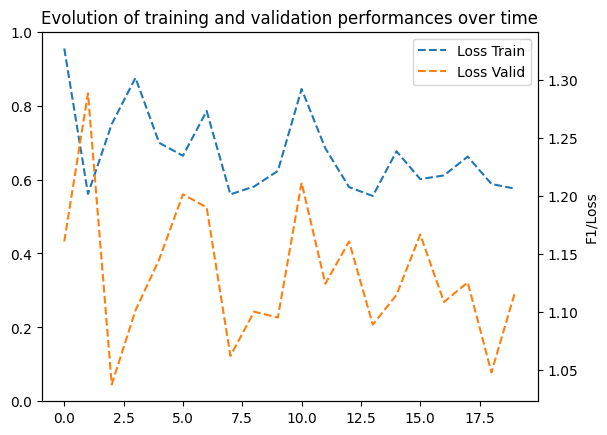

In [ ]:
ax = plt.gca()
twinx = ax.twinx()
twinx.plot(total_train_loss,label="Loss Train", linestyle="dashed")
twinx.plot(total_valid_loss,label="Loss Valid", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("F1/Loss")
plt.title("Evolution of training and validation performances over time")
ax.legend()
twinx.legend()

100%|██████████| 6/6 [00:00<00:00, 24.68it/s]


Confusion Matrix for PubMedBert:
[[0 9 0 0]
 [0 6 0 0]
 [0 6 0 0]
 [0 1 0 0]]


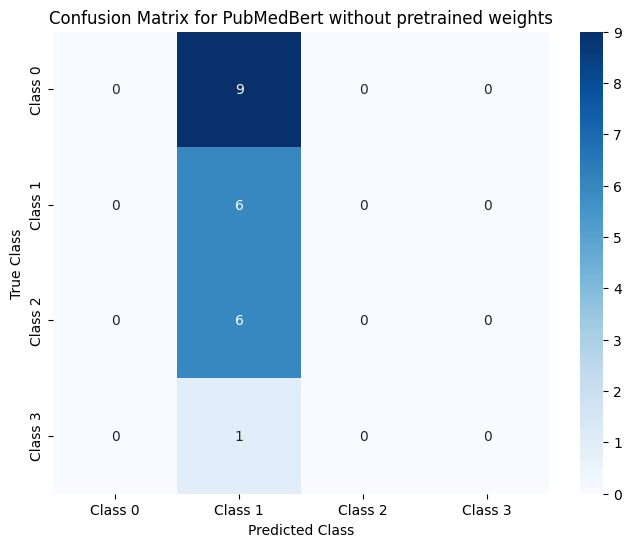

In [ ]:
#For PubMedBert
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to get predictions from the model
def get_predictions(model, dataloader):
    predictions = []
    true_labels = []

    model.eval()
    with torch.no_grad():
        for input_ids, attention_masks, labels in tqdm(dataloader):
            outputs = model(
                input_ids=input_ids.to(device), attention_mask=attention_masks.to(device)
            )
            predictions.extend(outputs.logits.argmax(-1).cpu().numpy())
            true_labels.extend(labels.numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions for the test set
test_dataset = ClassificationDataset(df, "Test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
predictions_bert, true_labels_bert = get_predictions(model, test_dataloader)

# Confusion matrix for PubMedBert
cm_bert = confusion_matrix(true_labels_bert, predictions_bert)
print("Confusion Matrix for PubMedBert:")
print(cm_bert)

# Visualize the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.title("Confusion Matrix for PubMedBert without pretrained weights")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


The results here show that the model is heavily biased towards class 1 and sample size is too little to train the model from scratch

# **Using BiomedBERT with pretrained weights**

Running on: cuda
Training with pretrained weights...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0 Validation: 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


Epoch 0: train F1=0.261, valid F1=0.427
New best validation F1: 0.427, model saved


Epoch 1 Validation: 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


Epoch 1: train F1=0.480, valid F1=0.610
New best validation F1: 0.610, model saved


Epoch 2 Validation: 100%|██████████| 2/2 [00:00<00:00, 14.18it/s]


Epoch 2: train F1=0.481, valid F1=0.656
New best validation F1: 0.656, model saved


Epoch 3 Validation: 100%|██████████| 2/2 [00:00<00:00, 13.55it/s]


Epoch 3: train F1=0.715, valid F1=0.643
No improvement in validation F1, patience counter: 1/4


Epoch 4 Validation: 100%|██████████| 2/2 [00:00<00:00, 14.20it/s]


Epoch 4: train F1=0.780, valid F1=0.657
New best validation F1: 0.657, model saved


Epoch 5 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


Epoch 5: train F1=0.870, valid F1=0.687
New best validation F1: 0.687, model saved


Epoch 6 Validation: 100%|██████████| 2/2 [00:00<00:00, 13.43it/s]


Epoch 6: train F1=0.919, valid F1=0.702
New best validation F1: 0.702, model saved


Epoch 7 Validation: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]


Epoch 7: train F1=0.943, valid F1=0.764
New best validation F1: 0.764, model saved


Epoch 8 Validation: 100%|██████████| 2/2 [00:00<00:00, 13.44it/s]


Epoch 8: train F1=0.994, valid F1=0.755
No improvement in validation F1, patience counter: 1/4


Epoch 9 Validation: 100%|██████████| 2/2 [00:00<00:00, 12.94it/s]


Epoch 9: train F1=1.000, valid F1=0.703
No improvement in validation F1, patience counter: 2/4


Epoch 10 Validation: 100%|██████████| 2/2 [00:00<00:00, 13.31it/s]


Epoch 10: train F1=1.000, valid F1=0.734
No improvement in validation F1, patience counter: 3/4


Epoch 11 Validation: 100%|██████████| 2/2 [00:00<00:00, 13.52it/s]


Epoch 11: train F1=1.000, valid F1=0.700
No improvement in validation F1, patience counter: 4/4
Early stopping triggered


Getting Predictions: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s]


Confusion Matrix for PubMedBERT with Pretrained Weights:
[[8 1 0 0]
 [0 6 0 0]
 [0 3 3 0]
 [0 1 0 0]]


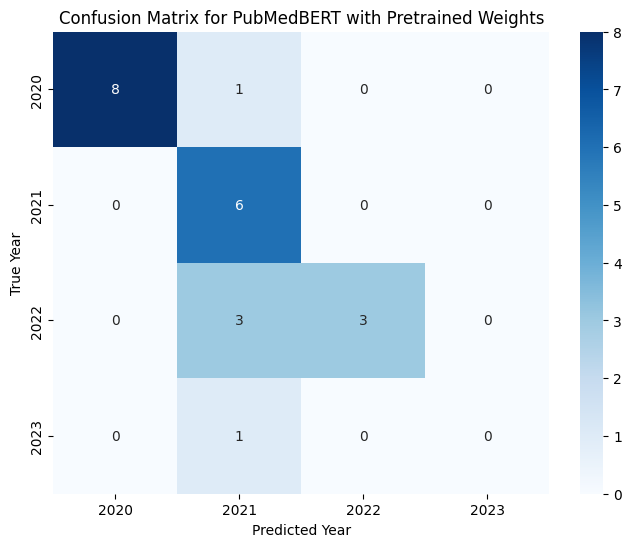

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

def do_tokenisation(texts, max_length):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

class ClassificationDataset(Dataset):
    def __init__(self, df, split):
        self.df = df[df.Split == split]
        self.tokeniser_output = do_tokenisation(self.df.Abstract.tolist(), max_length)
        self.labels = self.df.Year.values - 2020

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return (self.tokeniser_output["input_ids"][idx], self.tokeniser_output["attention_mask"][idx], self.labels[idx])

# Data setup
df["Abstract_Cleaned"] = df["Abstract"].apply(clean)
train_dataset = ClassificationDataset(df, "Train")
valid_dataset = ClassificationDataset(df, "Valid")
test_dataset = ClassificationDataset(df, "Test")
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def train_model():
    # Load pretrained weights
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    criterion = torch.nn.CrossEntropyLoss()
    N_EPOCHS = 20
    patience = 4
    best_valid_f1 = 0.0
    patience_counter = 0

    total_train_f1, total_valid_f1, total_train_loss, total_valid_loss = [], [], [], []

    for epoch in range(N_EPOCHS):
        model.train()
        train_f1, train_loss = [], []
        for input_ids, attention_masks, labels in tqdm(train_dataloader, desc=f"Epoch {epoch} Training"):
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            predictions = outputs.logits.argmax(-1)
            f1 = f1_score(labels.cpu(), predictions.cpu(), average="weighted")
            train_f1.append(f1)
            train_loss.append(loss.item())

        model.eval()
        valid_f1, valid_loss = [], []
        for input_ids, attention_masks, labels in tqdm(valid_dataloader, desc=f"Epoch {epoch} Validation"):
            with torch.no_grad():
                outputs = model(input_ids.to(device), attention_mask=attention_masks.to(device))
                loss = criterion(outputs.logits, labels.to(device))
                predictions = outputs.logits.argmax(-1)
                f1 = f1_score(labels.cpu(), predictions.cpu(), average="weighted")
                valid_f1.append(f1)
                valid_loss.append(loss.item())

        epoch_train_f1 = sum(train_f1) / len(train_f1)
        epoch_valid_f1 = sum(valid_f1) / len(valid_f1)
        print(f"Epoch {epoch}: train F1={epoch_train_f1:.3f}, valid F1={epoch_valid_f1:.3f}")

        if epoch_valid_f1 > best_valid_f1:
            best_valid_f1 = epoch_valid_f1
            patience_counter = 0
            torch.save(model.state_dict(), "best_model_pretrained.pt")
            print(f"New best validation F1: {best_valid_f1:.3f}, model saved")
        else:
            patience_counter += 1
            print(f"No improvement in validation F1, patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping triggered")
                model.load_state_dict(torch.load("best_model_pretrained.pt"))
                break

        total_train_f1.append(epoch_train_f1)
        total_valid_f1.append(epoch_valid_f1)
        total_train_loss.append(sum(train_loss) / len(train_loss))
        total_valid_loss.append(sum(valid_loss) / len(valid_loss))

    return model, total_train_f1, total_valid_f1, total_train_loss, total_valid_loss

# Function to get predictions
def get_predictions(model, dataloader):
    predictions = []
    true_labels = []
    model.eval()
    with torch.no_grad():
        for input_ids, attention_masks, labels in tqdm(dataloader, desc="Getting Predictions"):
            outputs = model(input_ids=input_ids.to(device), attention_mask=attention_masks.to(device))
            predictions.extend(outputs.logits.argmax(-1).cpu().numpy())
            true_labels.extend(labels.numpy())
    return np.array(predictions), np.array(true_labels)

# Train and evaluate the pretrained model
print("Training with pretrained weights...")
model_pretrained, _, _, _, _ = train_model()

# Get predictions for the pretrained model
predictions_pretrained, true_labels_pretrained = get_predictions(model_pretrained, test_dataloader)

# Confusion matrix for PubMedBERT with pretrained weights
cm_pretrained = confusion_matrix(true_labels_pretrained, predictions_pretrained)
print("Confusion Matrix for PubMedBERT with Pretrained Weights:")
print(cm_pretrained)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pretrained, annot=True, fmt="d", cmap="Blues",
            xticklabels=["2020", "2021", "2022", "2023"],  # Years instead of generic classes
            yticklabels=["2020", "2021", "2022", "2023"])
plt.title("Confusion Matrix for PubMedBERT with Pretrained Weights")
plt.xlabel("Predicted Year")
plt.ylabel("True Year")
plt.show()

The pretrained **PubMedBERT** model, fine-tuned on a large medical dataset, achieved an F1 score of 0.72 on the validation set, outperforming both model with PubmedBERT cofig but trained from scratch without pretrained weights and TF-IDF classifiers. Pretraining allows PubMedBERT to leverage domain-specific knowledge, improving its performance.